In [46]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

In [47]:
import SpykeTorch.utils as utils

kernels = [	utils.GaborKernel(window_size = 9, orientation = 45+22.5),
			utils.GaborKernel(9, 90+22.5),
			utils.GaborKernel(9, 135+22.5),
			utils.GaborKernel(9, 180+22.5)]
filter = utils.Filter(kernels, use_abs = True)

In [48]:
def time_dim(input):
	return input.unsqueeze(0)

In [49]:
import SpykeTorch.utils as utils
import SpykeTorch.functional as sf
import torchvision.transforms as transforms

transform = transforms.Compose(
	[transforms.Grayscale(),
	transforms.ToTensor(),
    transforms.Resize(114),
	time_dim,
	filter,
	sf.pointwise_inhibition,
	utils.Intensity2Latency(number_of_spike_bins = 15, to_spike = True)])

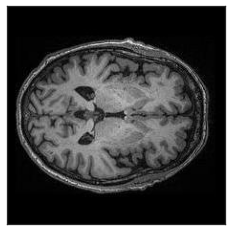

In [50]:
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random

train = ImageFolder("/Users/taraapple/Downloads/center/129new/train/")
test = ImageFolder("/Users/taraapple/Downloads/center/129new/test/")
sample_idx = random.randint(0, len(train) - 1)

# plotting the sample image
ax = plt.subplot(1,1,1)
plt.setp(ax, xticklabels=[])
plt.setp(ax, yticklabels=[])
plt.xticks([])
plt.yticks([])
plt.imshow(train[sample_idx][0])
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

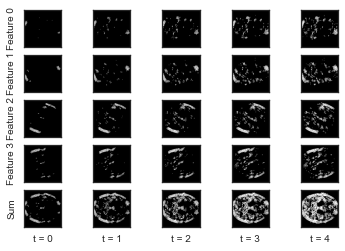

In [51]:
import numpy as np
train = ImageFolder("/Users/taraapple/Downloads/center/129new/train/", transform)
test = ImageFolder("/Users/taraapple/Downloads/center/129new/test/", transform) # adding transform to the dataset
plt.style.use('seaborn-white')
plt_idx = 0
sw = train[sample_idx][0]
for f in range(4):
	for t in range(5):
		plt_idx += 1
		ax = plt.subplot(5, 5, plt_idx)
		plt.setp(ax, xticklabels=[])
		plt.setp(ax, yticklabels=[])
		if t == 0:
			ax.set_ylabel('Feature ' + str(f))
		plt.imshow(sw[t,f].numpy(),cmap='gray')
		if f == 3:
			ax = plt.subplot(5, 5, plt_idx + 5)
			plt.setp(ax, xticklabels=[])
			plt.setp(ax, yticklabels=[])
			if t == 0:
				ax.set_ylabel('Sum')
			ax.set_xlabel('t = ' + str(t))
			plt.imshow(sw[t].sum(dim=0).numpy(),cmap='gray')
plt.show

In [52]:
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler

train = utils.CacheDataset(train)
test = utils.CacheDataset(test)
train_loader = DataLoader(train)
test_loader = DataLoader(test)

In [53]:
len(train_loader)

723

In [54]:
len(test_loader)

181

In [55]:
import SpykeTorch.snn as snn
pool = snn.Pooling(kernel_size = 7, stride = 2, padding=0)

In [56]:
conv = snn.Convolution(in_channels=4, out_channels=20, kernel_size=30, weight_mean=0.8, weight_std=0.02)

In [57]:
stdp = snn.STDP(conv_layer = conv, learning_rate = (0.05, -0.015), use_stabilizer=True, lower_bound=0, upper_bound=1)

In [59]:
conv.reset_weight()
anti_stdp = snn.STDP(conv_layer = conv, learning_rate = (-0.05, 0.0005))

In [60]:
feature2class = [0] * 10 + [1] * 10
print(feature2class)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [61]:
%%time
print("Starting Reinforcement Learning ...")
for iter in range(200):
    print('\rIteration:', iter + 1, end="")
    for data,targets in train_loader:
        for x,t in zip(data, targets):
            x = pool(x)
            p = conv(x)
            o, p = sf.fire(p, 20, return_thresholded_potentials=True)
            winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
            if len(winners) != 0:
                if feature2class[winners[0][0]] == t:
                    stdp(x, p, o, winners)
                else:
                    anti_stdp(x, p, o, winners)                 
print()
print("Reinforcement Learning is Done.")

Starting Reinforcement Learning ...
Iteration: 200
Reinforcement Learning is Done.
CPU times: user 23h 39min 44s, sys: 11min 36s, total: 23h 51min 20s
Wall time: 23h 26min 41s


In [80]:
error = 0
silent = 0
total = 0
actual=[]
pred=[]
for data,targets in train_loader:
    for x,t in zip(data, targets):
        pred.append(feature2class[winners[0][0]])
        actual.append(t)
        total += 1
        x = pool(x)
        p = conv(x)
        o, p = sf.fire(p, 20, return_thresholded_potentials=True)
        winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
        if len(winners) != 0:
            if feature2class[winners[0][0]] != t:
                error += 1
        else:
            silent += 1
print("         Error:", error/total)
print("Silent Samples:", silent/total)

         Error: 0.19225449515905949
Silent Samples: 0.0


In [81]:
import pandas as pd
pred=np.array(pred)
actual=np.array(actual)

In [82]:
y_actu = pd.Series(actual, name='Actual')
y_pred = pd.Series(pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

In [83]:
df_confusion

Predicted,0,1
Actual,,
0,329,31
1,109,254


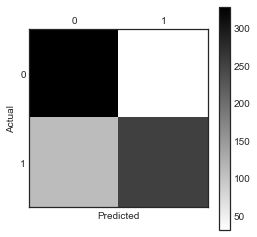

In [84]:
plot_confusion_matrix(df_confusion)

In [85]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_actu, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)

In [86]:
specificity

0.9138888888888889

In [87]:
sensitivity

0.699724517906336

In [67]:
test = ImageFolder("/Users/taraapple/Downloads/center/129new/test/", transform)
test = utils.CacheDataset(test)
test_loader = DataLoader(test)

In [68]:
len(test_loader)

121

In [69]:
error1 = 0
silent1 = 0
total1 = 0
actual1=[]
pred1=[]
for data,targets in test_loader:
    for x,t in zip(data, targets):
        pred1.append(feature2class[winners[0][0]])
        actual1.append(t)
        total1 += 1
        x = pool(x)
        p = conv(x)
        o, p = sf.fire(p, 20, return_thresholded_potentials=True)
        winners = sf.get_k_winners(p, kwta=1, inhibition_radius=0, spikes=o)
        if len(winners) != 0:
            if feature2class[winners[0][0]] != t:
                error1 += 1
        else:
            silent1 += 1
print("    Test Error:", error1/total1, "Silent Samples:", silent1/total1)

    Test Error: 0.371900826446281 Silent Samples: 0.0


In [70]:
actual1=np.array(actual1)
pred1=np.array(pred1)

In [71]:
import pandas as pd
y_actu = pd.Series(actual1, name='Actual')
y_pred = pd.Series(pred1, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)

In [72]:
df_confusion

Predicted,0,1
Actual,,
0,23,7
1,37,54


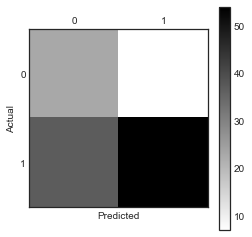

In [73]:
plot_confusion_matrix(df_confusion)

In [78]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_actu, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)

In [77]:
specificity

0.7666666666666667

In [79]:
sensitivity

0.5934065934065934

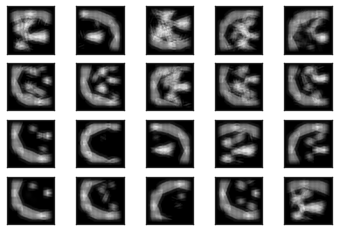

In [74]:
import SpykeTorch.visualization as vis
import torch
feature = torch.stack([k() for k in kernels])
cstride = (1,1)
# C1 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (9, 9), (2, 2))
# S2 Features #
feature,cstride = vis.get_deep_feature(feature, cstride, (30,30), (1,1), conv.weight)

feature_idx = 0
for r in range(4):
    for c in range(5):
        ax = plt.subplot(4, 5, feature_idx+1)
        plt.xticks([])
        plt.yticks([])
        plt.setp(ax, xticklabels=[])
        plt.setp(ax, yticklabels=[])
        plt.imshow(feature[feature_idx].numpy(),cmap='gray')
        feature_idx += 1
plt.show()